In [1]:
import pandas as pd

df = pd.read_csv("CarsData_cleaned.csv", sep=";")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

top_models = df['model'].value_counts().nlargest(100).index
df['model_grouped'] = df['model'].apply(lambda x: x if x in top_models else 'other')

df.head()

,model,year,price,transmission,mileage,fuelType,engineSize,Manufacturer,model_grouped
0,I30,2017,11500,Manual,11276,Petrol,1.4,hyundai,I30
1,Golf,2016,13991,Manual,20902,Petrol,1.4,volkswagen,Golf
2,C Class,2016,16750,Automatic,24909,Diesel,1.6,mercedes benz,C Class
3,Corsa,2020,16749,Manual,115,Petrol,1.2,opel,Corsa
4,GLA Class,2017,17889,Semi-Auto,42941,Diesel,2.1,mercedes benz,GLA Class


In [2]:
y = df['price']
X = df[['model_grouped', 'year','mileage','fuelType','transmission','engineSize','Manufacturer']]
X = pd.get_dummies(X, drop_first=True)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [4]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=500, max_depth=25, min_samples_split=10, min_samples_leaf=5, random_state=42)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=25, min_samples_leaf=5, min_samples_split=10,
                      n_estimators=500, random_state=42)

In [6]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, r2_score

lgb_model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=64,
    max_depth=-1,
    min_data_in_leaf=30,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

callbacks = [lgb.early_stopping(stopping_rounds=100)]

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='mae',
    callbacks=callbacks
)

y_pred = lgb_model.predict(X_test)
print("Keskmine absoluutne viga (MAE):", mean_absolute_error(y_test, y_pred))
print("R2 skoor:", r2_score(y_test, y_pred))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 78169, number of used features: 116
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 16764.079584
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[863]	valid_0's l1: 1345.03	val

In [7]:
y_pred = rf.predict(X_test)

print("Keskmine absoluutne viga (MAE):", mean_absolute_error(y_test, y_pred))
print("R2 skoor:", r2_score(y_test, y_pred))


Keskmine absoluutne viga (MAE): 1484.3747240736072
R2 skoor: 0.927737869848359


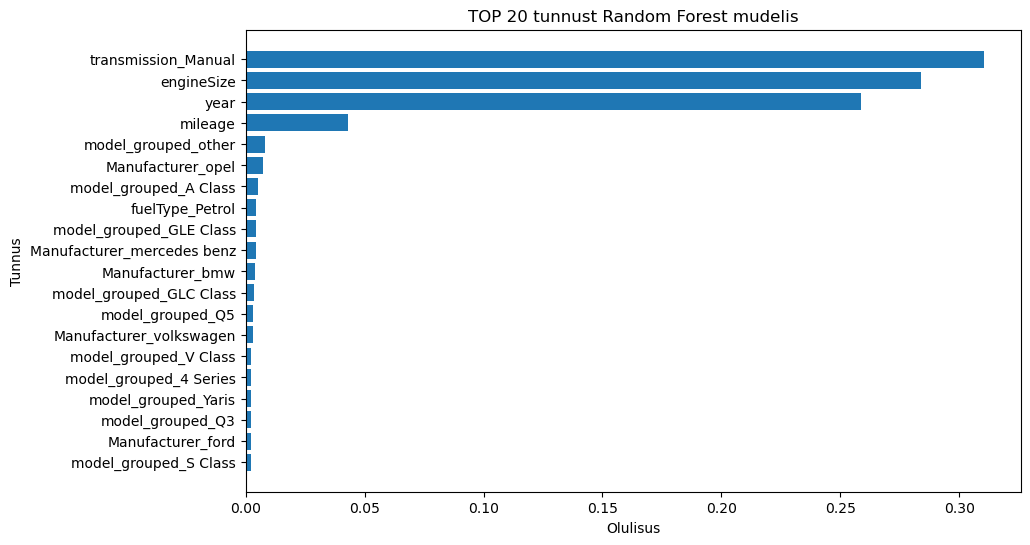

In [8]:
import matplotlib.pyplot as plt
import numpy as np

importances = rf.feature_importances_
features = X.columns

indices = np.argsort(importances)[::-1]
top_n = 20

plt.figure(figsize=(10,6))
plt.barh(range(top_n), importances[indices[:top_n]], align="center")
plt.yticks(range(top_n), [features[i] for i in indices[:top_n]])
plt.xlabel("Olulisus")
plt.ylabel("Tunnus")
plt.title("TOP 20 tunnust Random Forest mudelis")
plt.gca().invert_yaxis()
plt.show()

In [9]:
uus_auto = pd.DataFrame({
    'model_grouped':['5 Series'],
    'year':[2017],
    'mileage':[200000],
    'fuelType':['Diesel'],
    'transmission':['Automatic'],
    'engineSize':[2.0],
    'Manufacturer':['bmw']
})

uus_auto = pd.get_dummies(uus_auto)
uus_auto = uus_auto.reindex(columns=X.columns, fill_value=0)

hind = rf.predict(uus_auto)
print("Ennustatud hind:", hind[0])

Ennustatud hind: 13272.755514792254


In [10]:
hind = lgb_model.predict(uus_auto)
print("Uue auto ennustatud hind:", hind[0])

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Uue auto ennustatud hind: 12821.110831462562


In [12]:
import joblib

# Salvesta mudel
joblib.dump(rf, "models/randomForest.pkl")
joblib.dump(lgb_model, "models/lgbModel.pkl")

['models/lgbModel.pkl']

In [13]:
joblib.dump(X.columns, "models/X_columns.pkl")

['models/X_columns.pkl']

In [14]:
joblib.dump(df["model_grouped"].unique().tolist(), "models/model_grouped_values.pkl")
joblib.dump(df["fuelType"].unique().tolist(), "models/fuelType_values.pkl")
joblib.dump(df["transmission"].unique().tolist(), "models/transmission_values.pkl")
joblib.dump(df["engineSize"].unique().tolist(), "models/engineSize_values.pkl")
joblib.dump(df["Manufacturer"].unique().tolist(), "models/manufacturer_values.pkl")

['models/manufacturer_values.pkl']